I have an idea that I must check. What if we compare how many people watched the first episode of the series to how many watched the last one? In other words, we can make rating of a series based on how many people liked it so much that the watched all episodes up to the last one. I know, I know, there are many things that can go wrong in real-world (and spoiler alert, they will), but hey, we can try.

I don't know a reliable source of how many people watched an episode, but for our first attempt we can instead use information about how many people rated an episode. For this purpose, I'll use the [public IMDB dataset](https://www.imdb.com/interfaces/). It's one of the most popular databases of movies, the dataset is fresh, and it has all information we need.

Disclamer: I'll be using a lot of [pandas](https://pandas.pydata.org/) magic, but I don't know it as well as I should. So, some things for sure can be done easier than I do them. So, it's a good tutorial on what features pandas has, but might be a bad example on how and when to use them. Anyway, I've got the numbers I wanted to get, so it gets the job done! I guess that getting at the end the right numbers is all that matters when analyzing the data.

## Read raw datasets 

Read datasets:


In [1]:
import pandas
meta = pandas.read_csv('./title.basics.tsv.gz', sep='\t', low_memory=False)
meta.head(2)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"


In [2]:
eps = pandas.read_csv(
    './title.episode.tsv.gz', 
    sep='\t', 
    dtype=dict(seasonNumber='Int64', episodeNumber='Int64'), 
    na_values=r'\N',
)
eps.head(2)

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0020666,tt15180956,1,2
1,tt0020829,tt15180956,1,1


In [3]:
ratings = pandas.read_csv('./title.ratings.tsv.gz', sep='\t')
ratings.head(2)

,tconst,averageRating,numVotes
0,tt0000001,5.7,1895
1,tt0000002,5.9,253


## Create a new dataset

In [4]:
df1 = pandas.DataFrame()

In [5]:
df1['uid'] = meta.tconst
df1['title'] = meta.primaryTitle
df1.set_index('uid', inplace=True)

## The first episode

Insert for each series the first episode UID:

In [6]:
# filter
first_eps = eps[(eps.seasonNumber == 1) & (eps.episodeNumber == 1)]
# join
df2 = df1.join(first_eps.set_index('parentTconst'), how='inner')
# cleanup
del df2['seasonNumber']
del df2['episodeNumber']
df2.rename(columns={'tconst': 'first_uid'}, inplace=True)

Insert for each series the first episode rating and number of votes:

In [7]:
# join
df3 = df2.join(ratings.set_index('tconst'), on='first_uid', how='inner')
# cleanup
df3.rename(columns={'averageRating': 'first_rating', 'numVotes': 'first_votes'}, inplace=True)

Show the most popular first episodes:

In [8]:
df3.sort_values('first_votes', ascending=False).head(5)

,title,first_uid,first_rating,first_votes
tt2085059,Black Mirror,tt2089051,7.7,53564
tt7366338,Chernobyl,tt8162428,9.4,51882
tt0944947,Game of Thrones,tt1480055,9.0,46927
tt0903747,Breaking Bad,tt0959621,9.0,33343
tt1475582,Sherlock,tt1665071,8.9,31160


## The last episode

Find the last season number:

In [9]:
last_seasons = eps.groupby('parentTconst').max()
last_seasons = last_seasons.loc[eps.parentTconst].seasonNumber.to_numpy()
last_seasons = pandas.Series(last_seasons).astype('Int64')

Knowing the last season, we can filter only episodes in the last season, and find th last episode in each:

In [10]:
last_eps = eps[eps.seasonNumber == last_seasons].groupby('parentTconst').max()

Now, we can join it with our dataset in a similar manner to how we did it for first episodes:

In [11]:
# join
df4 = df3.join(last_eps, how='inner')
# cleanup
df4.rename(columns={'tconst': 'last_uid', 'seasonNumber': 'last_season', 'episodeNumber': 'last_episode'}, inplace=True)

And join with ratings for the last episodes:

In [12]:
# join
df5 = df4.join(ratings.set_index('tconst'), on='last_uid', how='inner')
# cleanup
df5.rename(columns={'averageRating': 'last_rating', 'numVotes': 'last_votes'}, inplace=True)

The most popular last episodes:

In [13]:
df5.sort_values('last_votes', ascending=False).head(5)

,title,first_uid,first_rating,first_votes,last_uid,last_season,last_episode,last_rating,last_votes
tt0944947,Game of Thrones,tt1480055,9.0,46927,tt6027920,8,6,4.1,244576
tt7366338,Chernobyl,tt8162428,9.4,51882,tt9166696,1,5,9.8,58982
tt0903747,Breaking Bad,tt0959621,9.0,33343,tt2301471,5,16,9.4,27789
tt1475582,Sherlock,tt1665071,8.9,31160,tt3845892,4,3,8.2,27430
tt9140560,WandaVision,tt9601584,7.3,25237,tt9601584,1,9,7.3,25237


## Stats

Let's get more numbers before we move to visualizations. First of all, let's filter out series that have just a few votes:

In [14]:
df6 = df5[df5.first_votes > 1000]
df6 = df6[df6.last_votes > 1000]

And since for our purpose we're particularly interested in ratio of first episode to last episode, let's make columns for the ratios:

In [15]:
df7 = df6.copy()
df7['votes_ratio'] = df7.last_votes / df7.first_votes
df7['rating_ratio'] = df7.last_rating / df7.first_rating

Series sorted by the difference in rating between the first and the last episodes:

In [16]:
df7.sort_values('rating_ratio', ascending=False)

,title,first_uid,first_rating,first_votes,last_uid,last_season,last_episode,last_rating,last_votes,votes_ratio,rating_ratio
tt0458290,Star Wars: The Clone Wars,tt1288767,7.3,4451,tt9313978,7,12,9.9,13536,3.041114,1.356164
tt3526078,Schitt's Creek,tt3653868,7.0,2468,tt10065390,6,14,9.3,2031,0.822934,1.328571
tt1759761,Veep,tt1927930,7.2,1644,tt7870762,7,7,9.4,1713,1.041971,1.305556
tt1305826,Adventure Time,tt1615520,7.5,2402,tt8164820,10,13,9.7,3300,1.373855,1.293333
tt4477976,Superstore,tt5171190,7.4,1452,tt13633896,6,15,9.5,1899,1.307851,1.283784
...,...,...,...,...,...,...,...,...,...,...,...
tt0369179,Two and a Half Men,tt0735172,8.2,2091,tt4450100,12,15,3.9,3028,1.448111,0.475610
tt0944947,Game of Thrones,tt1480055,9.0,46927,tt6027920,8,6,4.1,244576,5.211840,0.455556
tt7016936,Killing Eve,tt7062890,8.5,5274,tt15079460,4,8,3.3,6648,1.260523,0.388235
tt1856010,House of Cards,tt2161930,8.5,7915,tt7576210,6,8,2.6,7613,0.961845,0.305882


It's very convenient that pandas by default shows both the top and the bottom of the dataframe. The top 5 series in the list are the ones with last episode much better than the first one, and the bottom 5 series are other way arond, with a good start and bad finale.

## Drawing the tops

For drawing charts, I'll be using [plotnine](https://plotnine.readthedocs.io/en/stable/index.html). It's a very flexible (but not very popular) visualization library inspired by [ggplot](https://ggplot2.tidyverse.org/) libray from R and its powerful idea of "grammar of graphics". The upcoming nextgen interface of [seaborn](https://github.com/mwaskom/seaborn) will have something very similar. See [Next-generation seaborn interface](http://seaborn.pydata.org/nextgen/).

In [17]:
import plotnine as gg

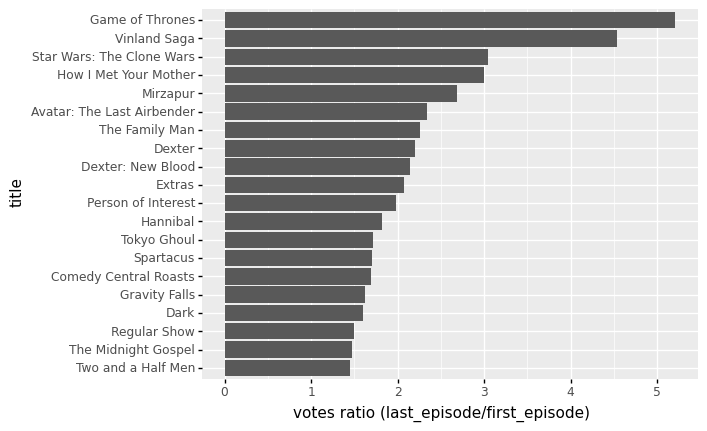

<ggplot: (8733744131955)>

In [18]:
df_plot = df7.sort_values('votes_ratio', ascending=False)[:20]
# https://github.com/has2k1/plotnine/issues/295
df_plot = df_plot.assign(title=pandas.Categorical(df_plot.title, df_plot.title[::-1], ordered=True))
(
    gg.ggplot(df_plot, gg.aes(x='title'))
    + gg.geom_col(gg.aes(y='votes_ratio'))
    + gg.ylab('votes ratio (last_episode/first_episode)')
    + gg.coord_flip()
)

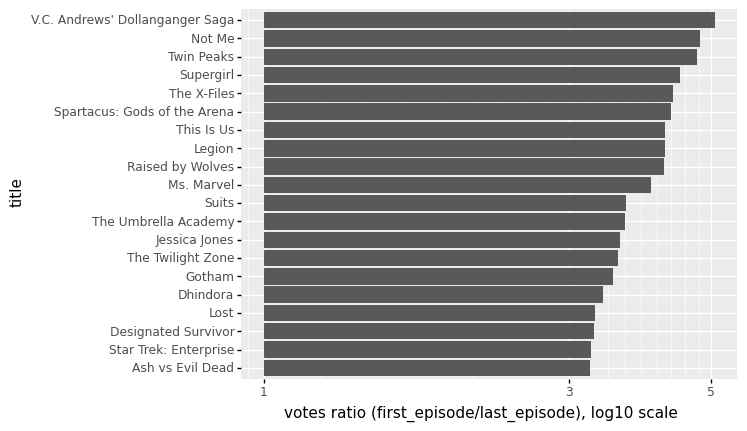

<ggplot: (8733741888919)>

In [19]:
df_plot = df7.sort_values('votes_ratio')[:20]
df_plot = df_plot.assign(title=pandas.Categorical(df_plot.title, df_plot.title[::-1], ordered=True))
(
    gg.ggplot(df_plot, gg.aes(x='title'))
    + gg.geom_col(gg.aes(y='1/votes_ratio'))
    + gg.ylab('votes ratio (first_episode/last_episode), log10 scale')
    + gg.scale_y_log10()
    + gg.coord_flip()
)

## Analyzing particular series

In [20]:
def get_series_uid(title):
    matches = meta[(meta.originalTitle.str.lower() == title.lower()) & (meta.titleType == 'tvSeries')]
    series_uid = matches.iloc[0].tconst
    print(f'https://www.imdb.com/title/{series_uid}')
    return series_uid

In [21]:
def get_episodes(series_uid):
    episodes = eps[eps.parentTconst == series_uid]
    episodes = episodes.set_index('tconst').join(ratings.set_index('tconst'), how='inner')
    episodes.sort_values(['seasonNumber', 'episodeNumber'], inplace=True)
    episodes['position'] = range(len(episodes))
    return episodes.reset_index()

In [22]:
def draw_episodes(title):
    uid = get_series_uid(title)
    episodes = get_episodes(uid)
    return (
        gg.ggplot(episodes, gg.aes(x='position', y='numVotes'))
        + gg.geom_line(gg.aes(group='seasonNumber'))
        + gg.geom_point(gg.aes(color='averageRating'))
        + gg.xlab('episodes')
        + gg.ylab('votes')
        + gg.ggtitle(f'Number of votes for each episode of {title}')
    )

https://www.imdb.com/title/tt0944947


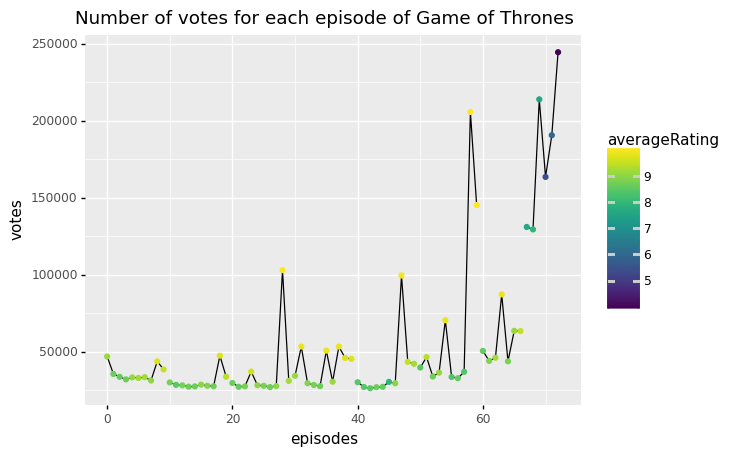

<ggplot: (8733741848893)>

In [23]:
draw_episodes('Game of Thrones')

https://www.imdb.com/title/tt0458290


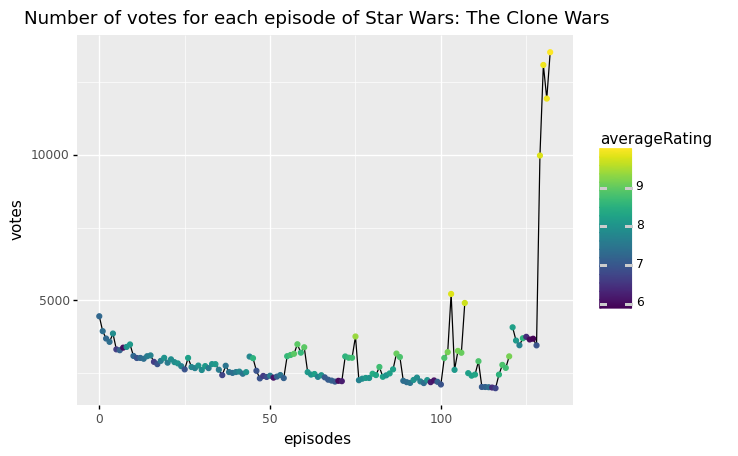

<ggplot: (8733741821742)>

In [24]:
draw_episodes('Star Wars: The Clone Wars')

https://www.imdb.com/title/tt0098936


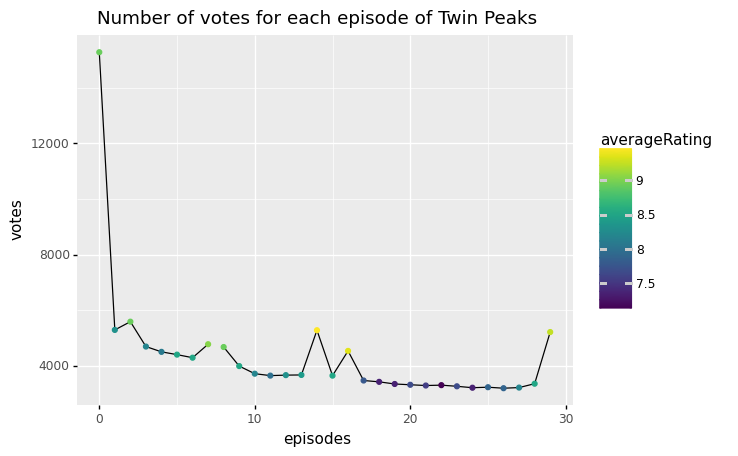

<ggplot: (8733741848028)>

In [25]:
draw_episodes('Twin Peaks')

https://www.imdb.com/title/tt0106179


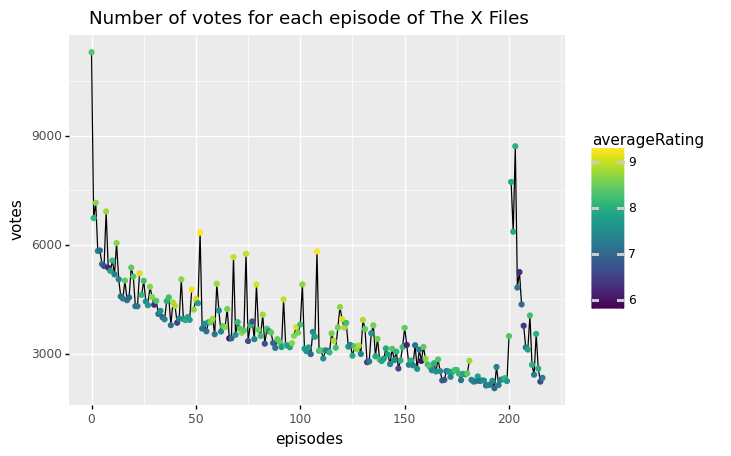

<ggplot: (8733741789769)>

In [26]:
draw_episodes('The X Files')